In [11]:
import requests 
import datetime as dt 
import json
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime

import torch 
import torch.nn as nn 
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import LSTM 
from tensorflow.keras import activations
from tensorflow.keras import layers


import warnings
warnings.filterwarnings('ignore')

In [12]:
#snowbird 
#USS0011J42S  40.5600 -111.6600 2938.3 UT Snowbird  
#park city 
#US1UTSM0007  40.7455 -111.6095 2083.3 UT PARK CITY 8.7 NW  


### Data Variable Dictionary 

* tavg = average temperature 
* tmax = max temp 
* tmin = min temp 
* tobs = temperature at time of observation 
* snow = inches snowed that day --> this will be our outcome variable 
* prcp = precipitation (measured in inches)
* snwd = snow depth 
* wesd = water equivalent of snow on ground (depth of water that would cover the ground if snow was liquid)

In [13]:
#Quick visualiztion 
def read_in_data():
    return pd.read_csv('../data/alta.csv')
data = read_in_data()


In [14]:
def make_quick_viz():
    df = data[['DATE', 'PRCP', 
               'TMAX', 'TMIN', 'SNOW']]
    
    plt.title("Histogram of Daily Snow Fall Totals Inches")
    plt.hist(data['SNOW'])
    plt.show()
    print(" ")
    plt.title("Correlation between Snow, Precipitaiton, Max Temp, Min Temp")
    df_corr = df[['PRCP', 'SNOW', 
               'TMAX', 'TMIN']].corr()
    sns.heatmap(df_corr)
    plt.show()
    
    return df 

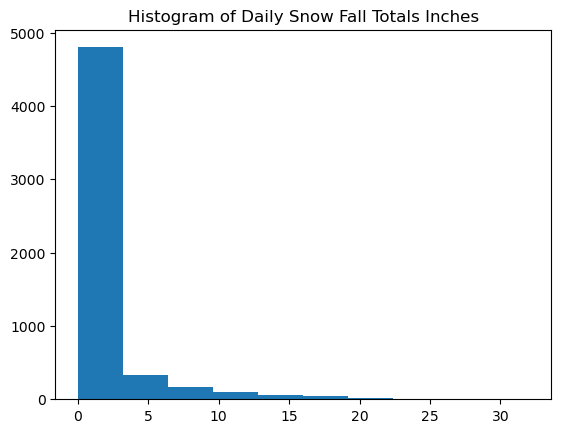

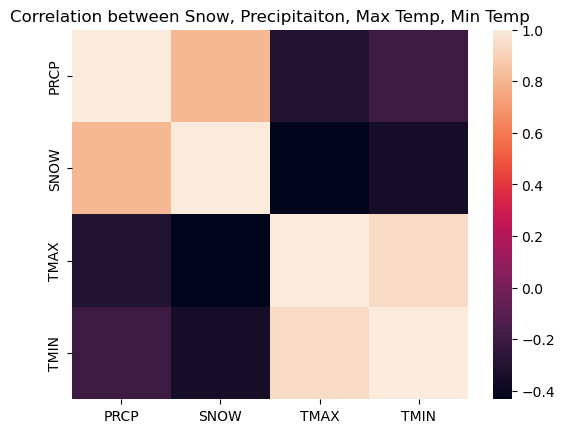

In [15]:
data2 = make_quick_viz()

As is the case with time series data, and as expected, there is a lot of cereal auto-correlation going on here. That presents some unique challenges when modeling because it essential means that we do not have any purely unique observations, we have like 5k observations, but none of those are truely independent except for perhasp the first. We will need to use non-linear methods to approximate this 

In [16]:
#incase i run on colab and want to use a GPU 
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

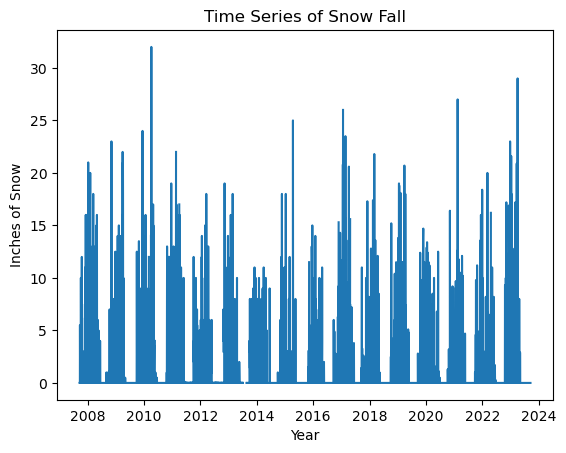

In [17]:
def convert_to_datetime(df):
    
    df['DATE'] = pd.to_datetime(df['DATE'])
    plt.title("Time Series of Snow Fall")
    plt.ylabel("Inches of Snow")
    plt.xlabel("Year")
    plt.plot(df['DATE'], df['SNOW'])
    plt.show()
    return df 
df = convert_to_datetime(data)

In [18]:
data2.isnull().sum()

DATE      0
PRCP    105
TMAX    135
TMIN    164
SNOW    213
dtype: int64

In [19]:
#got to view this null data 

n_df = data2.isnull().any(axis = 1)
null_rows = data2[n_df]

In [20]:
426/len(data2)

0.07422895974908521

In [21]:
def clean_null(df):
    
    
    df['DATE'] = pd.to_datetime(data2['DATE'])
    df['month'] = df['DATE'].apply(lambda x: x.month)
    df['day'] = df['DATE'].apply(lambda x: x.day)
    

    for col in df.columns.tolist():
        for i in range(len(df[col])):
            if str(df[col][i]) == 'nan':
                #subset = data2[(data2['month'] == 10) &(data2['day']==25)]
            
                df[col][i] = df[(df['month'] ==df['month'][i])&(df['day']==df['day'][i])][col].median()
            
            
    df = df.drop(columns = ['month', 'day'])       
    return df
    

In [22]:
data3 = clean_null(data2)

In [23]:
## Dont need to lag! 

In [24]:
def create_LSTM_data(df):
    
    #creating a copy
    df2 = df.copy()
    #setting index 
    df2.set_index("DATE", inplace = True)
    n_steps = [1]
    
    for col in df2.columns.tolist():
        for i in n_steps:
            df2[f'{col}_t_{i}'] = df2[col].shift(i)
    
    df2.dropna(inplace = True)
    #df2['output'] = df2.apply(lambda x: np.array([x['PRCP'], x['TMAX'], x['TMIN'], x['SNOW']]), axis = 1)
    return df2

In [25]:
#data4 = create_LSTM_data(data3)
#data4.head(3)

In [26]:
data3

,DATE,PRCP,TMAX,TMIN,SNOW
0,2007-09-19,0.00,64.0,41.0,0.0
1,2007-09-20,0.00,65.0,39.0,0.0
2,2007-09-21,0.00,66.0,43.0,0.0
3,2007-09-22,0.37,60.0,46.0,0.0
4,2007-09-23,0.50,49.0,37.0,0.1
...,...,...,...,...,...
5734,2023-09-14,0.01,58.0,38.0,0.0
5735,2023-09-15,0.00,60.0,39.0,0.0
5736,2023-09-16,0.00,62.0,40.0,0.0
5737,2023-09-17,0.00,64.0,43.0,0.0


In [27]:
def get_data_organized(df):
    df.set_index("DATE", inplace = True)
    #snow = df['SNOW']
    #df['output'] = df.apply(lambda x: np.array([x['PRCP'], x['TMAX'], x["TMIN"], x["SNOW"]]), axis = 1)
    #df2 = df.drop(columns = ['SNOW', 'TMAX', 'TMIN', 'PRCP'])
    
    #df2['SNOW'] = snow
    
    return df

In [29]:
data5 = get_data_organized(data3)

In [30]:
data5

,PRCP,TMAX,TMIN,SNOW
DATE,,,,
2007-09-19,0.00,64.0,41.0,0.0
2007-09-20,0.00,65.0,39.0,0.0
2007-09-21,0.00,66.0,43.0,0.0
2007-09-22,0.37,60.0,46.0,0.0
2007-09-23,0.50,49.0,37.0,0.1
...,...,...,...,...
2023-09-14,0.01,58.0,38.0,0.0
2023-09-15,0.00,60.0,39.0,0.0
2023-09-16,0.00,62.0,40.0,0.0


In [31]:
def scale_data(df):
    scaler = MinMaxScaler(feature_range = (-1,1))
    scaled_df = scaler.fit_transform(df)
    return scaled_df, scaler

In [32]:
scaled_data, total_scaler = scale_data(data5)

In [33]:
#scaled_y, scaler_y = scale_data(data5[['SNOW']])

In [34]:
#scaled_df_x, scaler_x = scale_data(data5[['PRCP', "TMAX", "TMIN"]])

In [35]:
data5.loc['2007-01-01':'2022-09-27']

,PRCP,TMAX,TMIN,SNOW
DATE,,,,
2007-09-19,0.00,64.0,41.0,0.0
2007-09-20,0.00,65.0,39.0,0.0
2007-09-21,0.00,66.0,43.0,0.0
2007-09-22,0.37,60.0,46.0,0.0
2007-09-23,0.50,49.0,37.0,0.1
...,...,...,...,...
2022-09-23,0.00,56.0,33.0,0.0
2022-09-24,0.00,59.0,34.0,0.0
2022-09-25,0.00,62.0,39.0,0.0


In [36]:
# train_x = X[-5376:,]
# test_x = X[5376:, ]
# train_y = y[-5376:,]
# test_y = y[5376:, ]

In [37]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
    # check if we are beyond the dataset

        if out_end_ix > len(sequences):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [38]:
look_back = 7
predict = 1

In [40]:
seq_x, seq_y = split_sequences(scaled_data, look_back, predict)

In [41]:
seq_x[0]


array([[-1.        ,  0.53658537,  0.40740741],
       [-1.        ,  0.56097561,  0.35802469],
       [-1.        ,  0.58536585,  0.45679012],
       [-0.83181818,  0.43902439,  0.5308642 ],
       [-0.77272727,  0.17073171,  0.30864198],
       [-0.59090909, -0.12195122, -0.03703704],
       [-1.        ,  0.04878049, -0.13580247]])

In [42]:
seq_y[0]

array([-1.])

In [43]:

train_x = seq_x[-5376:,]
test_x = seq_x[5376:, ]
train_y = seq_y[-5376:,]
test_y = seq_y[5376:, ]

In [44]:
print(len(train_x))
print(len(train_y))
print(len(test_x))
print(len(test_y))

5376
5376
357
357


In [45]:
n_features = train_x[0].shape[1]

In [46]:
n_features

3

### Build deep learning model 

In [47]:
opt = keras.optimizers.Adam(learning_rate = 0.0001)

In [48]:
model = Sequential()
model.add(LSTM(50, layers.Activation(activations.relu), return_sequences = True, input_shape = (look_back, n_features)))
model.add(LSTM(50, layers.Activation(activations.relu)))
model.add(Dense(predict))
model.add(layers.Activation(activations.linear))
model.compile(loss = 'mse', optimizer = opt, metrics = ['accuracy'])

In [49]:
history = model.fit(train_x, train_y, 
                    epochs = 1000, steps_per_epoch = 25, verbose = 1, validation_data = (test_x, test_y), 
                    shuffle = False) 

Epoch 1/1000
25/25 [==============================] - 3s 23ms/step - loss: 0.8508 - accuracy: 0.0013 - val_loss: 0.7558 - val_accuracy: 0.0000e+00
Epoch 2/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.7604 - accuracy: 0.0013 - val_loss: 0.6713 - val_accuracy: 0.0000e+00
Epoch 3/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.6650 - accuracy: 0.0013 - val_loss: 0.5763 - val_accuracy: 0.0000e+00
Epoch 4/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.5512 - accuracy: 0.0013 - val_loss: 0.4602 - val_accuracy: 0.0000e+00
Epoch 5/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.4095 - accuracy: 0.0013 - val_loss: 0.3154 - val_accuracy: 0.0000e+00
Epoch 6/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.2434 - accuracy: 0.0013 - val_loss: 0.1649 - val_accuracy: 0.0000e+00
Epoch 7/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.1067 - accuracy: 0.0013 - val_loss: 0.084

In [50]:
print("Done training") 

Done training


In [51]:
y_pred = model.predict(test_x)

12/12 [==============================] - 0s 2ms/step


In [52]:
y_pred_inv = scaler_y.inverse_transform(y_pred)

NameError: name 'scaler_y' is not defined

In [ ]:
sum(np.abs(y_pred_inv))

In [ ]:
plt.plot(np.abs(y_pred_inv))

In [ ]:
y

In [ ]:
y_pred_inv

In [ ]:
def make_new_preds():
    import datetime
    last_pred = data5.tail(7)
    new_date = last_pred.tail(1).index.date 
    dates = []
    dates.append(new_date[0])
    while new_date <= datetime.date(2024, 5, 31):
        new_date += datetime.timedelta(days=1)
        
        dates.append(new_date[0])
    return dates
     

In [404]:
import datetime

(data5.tail(7).tail(1).index + pd.DateOffset(1)).date < datetime.date(2024, 5, 31)

array([ True])

In [347]:
import datetime
datetime.date(2024, 5, 31)

datetime.date(2024, 5, 31)